<a href="https://colab.research.google.com/github/uddaloksarkar/SuperVAE/blob/master/SuperVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Description
**Salient Object Detection(SOD)** is the detection and segmentation of salient objects or regions. Salient means “most noticeable or important”. So, salient object detection is the detection of the most noticeable or important object in an image. There has been increasingly many works in this domain. More generally two types of methods have been used. 

1.   **Pixel-wise** CNN methods suffers from blurryness due to convolution and spatial poolings
2.   **Region-based** approached on the other hand lacks spatial consistency as they deal with each region independently.

In this work, we have designed salient object detection framework using a **superpixel-wise variational autoencoder (SuperVAE) network**. This method is an unsupervised approach of Salient object detection which works without the supervision of mask-level annotated data.


# Method
This framework of salient object etection is based on the work **SuperVAE: Superpixelwise Variational Autoencoder for Salient Object Detection** ([Li et al.](https://dl.acm.org/doi/pdf/10.1609/aaai.v33i01.33018569casa_token=k2l28UcCmE8AAAAA:Jxs3LwJU1K1uTtDT66qcd_bhk6kBuz_DrI8C3i_eSc5iNraHuy2_fXsqzZLEnUb61TJ71crKhHY)), which uses the concept of Variational Auto-Encoder. The concept of this work based on the following assumption: The boudary region describes the background of an image. So if we can somehow design the background of the image, we can obtain the Salient object inside it. To design this background we need a generative framework for which we used VAE.

The steps of the algorithm is as follows:
 
1.   We preprocessed the image by segmenting it into Superpixels. For a 300 x 400 images we segmented it into three scales (150, 250, 350).
2.   From the obtained Superpixels we extracted the boundary Superpixels, and trained a VAE using the superpixels. The parameters of the VAE framework is as shown in the image.
3.   While training the VAE we incorporate a perceptual loss along with the KL-divergence and reconstruction loss. The main idea is to seek consistency between hidden representation of two images (original and generated). We replaced the generated Superpixel into the corresponding slot in the image and fed the original image and obtained image to a VGG19 net and measured the losses from the feature-maps. This actually takes into consideration the dependecy of the Superpixels.
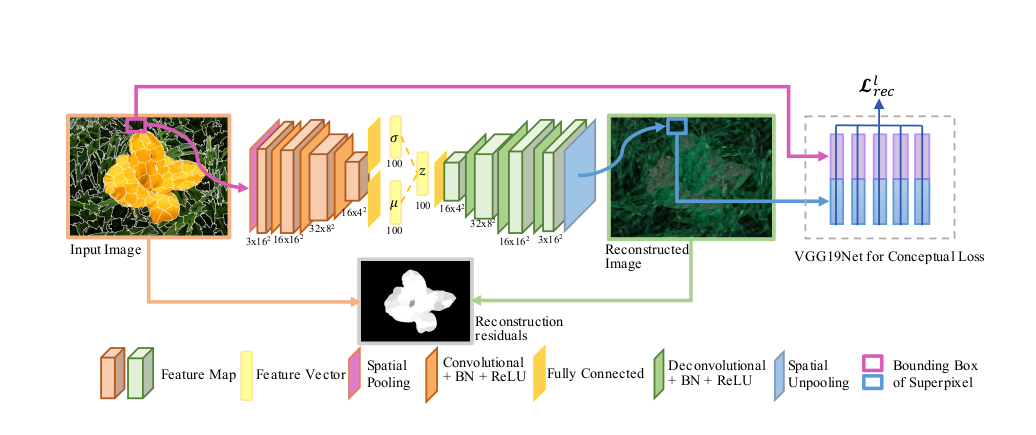
The details of the method will be discussed step by step later.

# Dataset
We are using **ECSSD** (Shi et al. 2016) dataset contains $1,000$
natural images, also it contains $1000$ images which contains ground truth(GT). The Dataset is available [here](www.cse.cuhk.edu.hk/leojia/projects/hsaliency/dataset.html).





# 1. Prerequisites

### Import Libraries

In [ ]:
! pip install scikit-image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision as tv
from torchvision import transforms as T
from torchvision.utils import save_image

from IPython import display

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from PIL import Image
from skimage.segmentation import slic, mark_boundaries
from skimage.measure import regionprops 
import skimage.color as color
from skimage import transform, io

from collections import namedtuple


In [ ]:
def imshow(imgTensor):
  plt.imshow(transforms.functional.to_pil_image(imgTensor))
  return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data
please import an image with name "**image.jpg**" to run the algorithm 

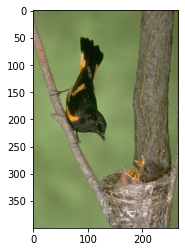

In [ ]:
imT = tv.io.read_image("image.jpg")
im = np.array(T.functional.to_pil_image(imT))
plt.imshow(im)
# img.shape

imtrans = T.Compose([T.ToTensor(),
                    # T.Normalize(
                    #   mean=[0.485, 0.456, 0.406],  # ImageNet mean and std
                    #   std=[0.229, 0.224, 0.225],
                    #   )
                    ])
imT = imtrans(im)

# im: numpy version
# imT: torch tensor version

# 2. SLIC (simple linear iterative clustering)
This method ([Achanta et al. 2012](https://ieeexplore.ieee.org/document/6205760)) is a k-means based iterative algorithm to segment an image into SuperPixels. Here we are using SLIC to find 350 superpixels of each images which will further help us to predict the background. We will reconstuct the background from the boundary superpixels with the assumption that boundary superpixels are candidate superpixels for the background. We first over segment the image into superpixels by SLIC algorithm . We then select the background samples from the image boundary. These back-ground superpixels are used to train the proposed VAE network through the perceptual loss.

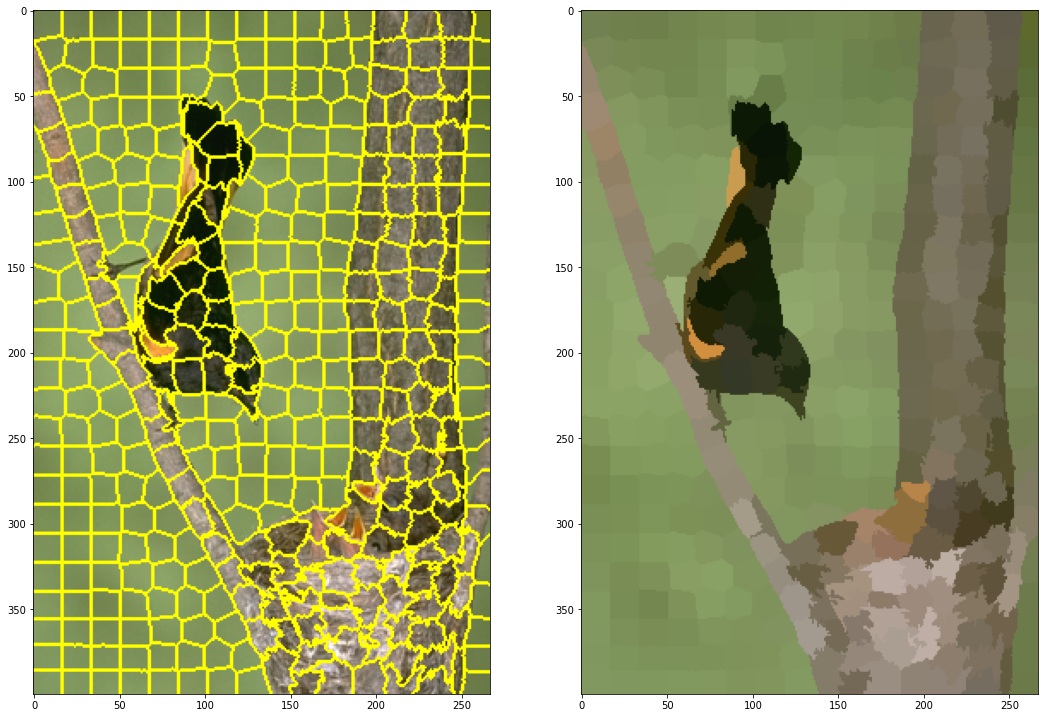

In [ ]:
# run SLIC
seg = slic(im, n_segments = 350, compactness = 20, start_label=1)
out = color.label2rgb(seg, im, kind='avg', bg_label = 0)

fig = plt.figure(figsize=(18, 18))
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(im, seg))
plt.subplot(1, 2, 2)


plt.imshow(out.astype(np.uint8))

### Retrieving The Boundary Superpixels

In [ ]:
# retrieve the boundary superpixels and its properties

props = regionprops(seg, intensity_image=np.asarray(im))  # properties of all SuperPixel

bndryProp = []  # contain properties of boundary Superpixel
boundary = []   # contain boundary SuperPixel (3 x 16 x 16)

for prop in props:
  if 0 in prop.bbox or im.shape[0] in prop.bbox or im.shape[1] in prop.bbox:
    bndryProp.append(prop)
    buff = im[prop.bbox[0]:prop.bbox[2]][:, prop.bbox[1]:prop.bbox[3]]
    boundary.append(transform.resize(buff, (16, 16)))
boundary[10].shape

T.functional.to_tensor(boundary[10]).shape

torch.Size([3, 16, 16])

In [ ]:
prop = props[9]
prop.image.shape

(18, 16)

In [ ]:
# boundary[0]
p = bndryProp[43]
p.image.shape
# plt.imshow(p)

(26, 15)

### Training Dataset

In [ ]:
# Define Custom DataSet Class

class SuperPixelDataset(Dataset):
  
  def __init__(self, RegionProps, transform=None):
      # assert all(tensors[0].shape == tensor.shape for tensor in tensors)
      self.RegionProps = RegionProps
      self.transform = transform

  def __getitem__(self, index):
      prop = self.RegionProps[index]
      x = np.asarray((im[prop.bbox[0]:prop.bbox[2]][:, prop.bbox[1]:prop.bbox[3]]))
      
      if self.transform:
          x = self.transform(x)
      # x = torch.transpose(torch.transpose(torch.tensor(x).float(), 0, 2), 1, 2)
      
      return x, index #prop

  def __len__(self):
      return len(self.RegionProps)

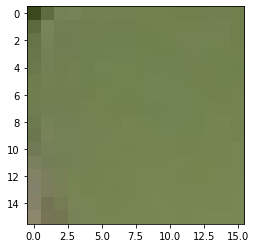

In [ ]:
# Resize Snippet for the numpy version of image to work with skimage
def resize(img, shape = (16, 16)):
  return transform.resize(img, shape)
  
  

# Transform Pipeline for Dataset construction
Dtransform = T.Compose([T.ToTensor(),
                        T.Resize((16,16)),
                      #  T.Normalize(
                      #      mean=[0.485, 0.456, 0.406],  # ImageNet mean and std
                      #      std=[0.229, 0.224, 0.225],
                      #  )
                        ])


# training DataSet (Boundary SuperPixels)
trainData = SuperPixelDataset(bndryProp, Dtransform)
trainData.__getitem__(0)[0].shape


p = T.functional.to_pil_image(trainData.__getitem__(0)[0])
plt.imshow(np.asarray(p))
# display.display(p)

# 3. VAE (Variational AutoEncoder Framework)

**Variational AutoEncoder Framework:** It contains $3$ convolutional layers in the encoder network with $3×3$ kernels. The stride
of first layer is $1$, while the strides of other two layers are
set to be $2$ to achieve spatial downsampling instead of using
deterministic spatial functions such as pooling. Each convolutional
layer is followed by an adaptive batch normalization
layer and a ReLU activation layer.

As a symmetric architecture, we use $3$ deconvolutional
layers with the same $3×3$ kernel size in the decoder network.
For upsampling we use nearest neighbor method by a scale
of $2$ instead of standard zero-padding. We also add batch
normalization layer and ReLU activation layer following deconvolutional
layer to help stabilize training. Also added a fully connected layer.

Reconstruction Loss: $λ_{rec}=-Ε_{q(z|x)}\log (p(x|z))$
\
Divergence Loss: $λ_{kl}=D_{KL}(q(z|x)||p(z))$
\
VAE models will
be trained by optimizing the sum of the reconstruction loss
 and KL divergence loss i,e.  $λ_{vae}=λ_{rec}+λ_{kl}$


In [46]:
class Encoder(nn.Module):

  def __init__(self, nchannel, interdims, latent):
    
    super().__init__()
    self.interDims = interdims
    self.nchannel = nchannel
    self.conv1 = nn.Conv2d(nchannel, interdims[0], kernel_size = 3, stride = 1, padding = 1)  # kernel is of size 3 x 3 x nchannel
    self.BN1 = nn.BatchNorm2d(interdims[0])
    self.conv2 = nn.Conv2d(interdims[0], interdims[1], kernel_size = 3, stride = 2, padding = 1)  # stride of 2 used instead of maxpooling
    self.BN2 = nn.BatchNorm2d(interdims[1])
    self.conv3 = nn.Conv2d(interdims[1], interdims[2], kernel_size = 3, stride = 2, padding = 1) # stride of 2 used instead of maxpooling
    self.BN3 = nn.BatchNorm2d(interdims[2])
    # self.dropout1 = nn.Dropout2d(0.25)                                          # dropout b/w 2nd and 3rd layer
    # self.dropout2 = nn.Dropout2d(0.5)                                           # dropout b/w 3rd and 4th layer
    # self.fc = nn.Linear(256, latent)                                             # all superpixels are resized to 16 x 16 


  
  def forward(self, x):
    
    assert (x.shape[2] == 16 and x.shape[3] == 16), 'Please resize image dimensions to 16 x 16'
    
    x = F.relu(self.BN1(self.conv1(x)))
    x = F.relu(self.BN2(self.conv2(x)))
    # x = self.dropout1(x)
    x = F.relu(self.BN3(self.conv3(x)))
    batch, _, _, _ = x.shape
    x = x.reshape(batch, -1) 
    # h_enc = self.fc(x)

    return x #h_enc
    

In [47]:
class Decoder(nn.Module):

  def __init__(self, interdims, nchannel, latent):

    super().__init__()
    self.interDims = interdims
    self.nchannel = nchannel
    self.conv1 = nn.ConvTranspose2d(interdims[0], interdims[1], kernel_size = 4, stride = 2,  padding = 1)  # stride of 2 used instead of maxpooling
    self.BN1 = nn.BatchNorm2d(interdims[1])
    self.conv2 = nn.ConvTranspose2d(interdims[1], interdims[2], kernel_size = 4, stride = 2,  padding = 1)  # stride of 2 used instead of maxpooling
    self.BN2 = nn.BatchNorm2d(interdims[2])
    self.conv3 = nn.ConvTranspose2d(interdims[2], nchannel, kernel_size = 3, stride = 1,  padding = 1)   # kernel is of size 3 x 3 x nchannel
    self.BN3 = nn.BatchNorm2d(nchannel)
    # self.dropout1 = nn.Dropout2d(0.25)                                          # dropout b/w 2nd and 3rd layer
    # self.dropout2 = nn.Dropout2d(0.5)                                           # dropout b/w 3rd and 4th layer
    self.fc = nn.Linear(latent, 256)                                             # all superpixels are resized to 16 x 16 
    

  def forward(self, x):
    x = F.relu(self.fc(x))
    x = x.view(-1, self.interDims[0], 4, 4)
    x = F.relu(self.BN1(self.conv1(x)))
    x = F.relu(self.BN2(self.conv2(x)))
    # x = self.dropout1(x)
    x = F.relu(self.BN3(self.conv3(x)))
    # x = nn.Sigmoid(x)

    return x
    

In [48]:
class VAE(nn.Module):

  def __init__(self, nchannel, interdims, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(nchannel, interdims, latent_dim)
    self.decoder = Decoder(interdims, nchannel, latent_dim)
    self._enc_mu = nn.Linear(256, self.latent_dim)
    self._enc_log_sigma = nn.Linear(256, self.latent_dim)
    # self._dec_Z = nn.Linear(self.latent_dim, 256)

  def _sample_latent(self, h_enc):
    """
    Return the latent normal sample z ~ N(mu, sigma^2)
    """
    mu = self._enc_mu(h_enc)
    log_sigma = self._enc_log_sigma(h_enc)
    sigma = torch.exp(log_sigma)
    std_z = torch.randn(*sigma.size()).to(device)

    self.z_mean = mu
    self.z_logvar = log_sigma.pow(2)

    return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

  def forward(self, state):
    h_enc = self.encoder(state)
    z = self._sample_latent(h_enc)
    # z_dec = self._dec_Z(z)
    return self.decoder(z),self.z_mean, self.z_logvar




# 4. SuperVAE

Training VAE using  background Superpixels

In [49]:
input_dim = (16, 16)
batch_size = 10 

# transform = transforms.Compose(
#     [transforms.ToTensor()])
# mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(trainData, batch_size=batch_size,
                                          shuffle=True, num_workers=2) 

print('Number of Training samples: ', len(trainData))

Number of Training samples:  75


In [50]:
latent_dim = 100
nchannel = 3
interDims = [16, 32, 16]

# encoder = Encoder(nchannel, interDims)
# decoder = Decoder(interDims, nchannel)
vae = VAE(nchannel, interDims, latent_dim)

# initialize the model
vae = vae.to(device)
print(vae)

# set the learning parameters
lr = 0.01
epochs = 200
batch_size = 10
optimizer = optim.Adam(vae.parameters(), lr=lr)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (BN3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(

encoder.conv1.weight torch.Size([16, 3, 3, 3])
encoder.conv1.bias torch.Size([16])
encoder.BN1.weight torch.Size([16])
encoder.BN1.bias torch.Size([16])
encoder.conv2.weight torch.Size([32, 16, 3, 3])
encoder.conv2.bias torch.Size([32])
encoder.BN2.weight torch.Size([32])
encoder.BN2.bias torch.Size([32])
encoder.conv3.weight torch.Size([16, 32, 3, 3])
encoder.conv3.bias torch.Size([16])
encoder.BN3.weight torch.Size([16])
encoder.BN3.bias torch.Size([16])
decoder.conv1.weight torch.Size([16, 32, 4, 4])
decoder.conv1.bias torch.Size([32])
decoder.BN1.weight torch.Size([32])
decoder.BN1.bias torch.Size([32])
decoder.conv2.weight torch.Size([32, 16, 4, 4])
decoder.conv2.bias torch.Size([16])
decoder.BN2.weight torch.Size([16])
decoder.BN2.bias torch.Size([16])
decoder.conv3.weight torch.Size([16, 3, 3, 3])
decoder.conv3.bias torch.Size([3])
decoder.BN3.weight torch.Size([3])
decoder.BN3.bias torch.Size([3])
decoder.fc.weight torch.Size([256, 100])
decoder.fc.bias torch.Size([256])
_enc_m

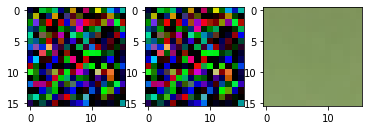

In [51]:
# Check how untrained VAE is working on a random input

inputs, ind = next(iter(dataloader))

dec,_,_ = vae(inputs[0].unsqueeze(0).to(device, dtype = torch.float))

# print(dec[0], "\n", np.asarray(transforms.functional.to_pil_image(dec[0])))

plt.subplot(1,3,1)
plt.imshow(np.asarray(T.functional.to_pil_image(dec.detach()[0])))

# Scale the following normalized image by 255 before printing  
plt.subplot(1,3,2)
# print(dec[0], "\n", np.array(dec.detach().numpy()[0].transpose(1,2,0), np.int32))
plt.imshow(np.array(dec.detach().cpu().numpy()[0].transpose(1,2,0) * 255, np.uint8))

plt.subplot(1,3,3)
plt.imshow(np.asarray(T.functional.to_pil_image(inputs[0])))

for name, param in vae.named_parameters():
  if param.requires_grad:
    print(name, param.data.shape)
print("Total param:", sum(p.numel() for p in vae.parameters() if p.requires_grad))

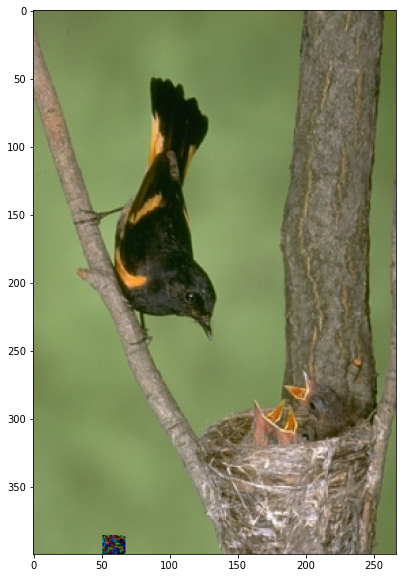

In [52]:
# Replace the a SuperPixel with newly generated SuperPixel from the VAE

def replacePixel(image, spixels, indices, TRAIN):

  '''if TRAIN parameter is True only the boundary Superpixels are substituted'''
  

  outTensor = torch.empty((spixels.shape[0], spixels.shape[1], image.shape[0], image.shape[1]))
  
  for i in range(len(spixels)):
    index = indices[i]
    spixel = spixels[i]

    if TRAIN:
      prop = bndryProp[index]
    else:
      prop = props[index]
      
    bbox = prop.bbox

    trans = T.Compose([
                      # T.Normalize(
                      #     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],  #inverse transform
                      #     std=[1/0.229, 1/0.224, 1/0.225]
                      # ),
                      T.ToPILImage(),
                      T.Resize((bbox[2] - bbox[0], bbox[3] - bbox[1]))])
    
    spixel = np.asarray(trans(spixel))
  
    filter1 = np.zeros_like(image)
    filter2 = np.ones_like(image)
    
    for coord in prop.coords:
      filter1[coord[0]][coord[1]] = spixel[coord[0] - bbox[0]][coord[1] - bbox[1]]
      filter2[coord[0]][coord[1]] = 0

    out = image * filter2 + filter1  
    trans2 = T.Compose([T.ToTensor(),
                        #  T.Normalize(
                        #     mean=[0.485, 0.456, 0.406], 
                        #     std=[0.229, 0.224, 0.225]
                        # )
                        ])
    outTensor[i] = trans2(out)

  # assert im.shape == out.shape
  
  return outTensor.to(device)

fig = plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(T.functional.to_pil_image\
                      (replacePixel(im, dec.detach(), ind, 1)[0])))

## Perceptual Loss and VGG19 
**Perceptual Loss**: perceptual loss of two images is the difference between
the hidden features in a pre-trained deep convolutional
neural network $ϕ$, The core idea of feature perceptual
loss is to seek the consistency between the hidden representations
of two images. Specifically, the 19-layer pre-trained VGGNet
(Simonyan and Zisserman 2014) is chosen as loss network $ϕ$
to construct the perceptual loss.


Let $x$ represents a superpixel
in image $I$, and $x̄$ represents corresponding VAE output.
We first perform
spatial unpooling over $x̄$ to restore it to its original superpixel
size. Then we fill this reconstructed superpixel $x̄$ into
its corresponding location in the original image $I$ and obtain
a new image $I'$. Next, let $ϕ(I)^l$ represents the feature map
of the $l^{th}$ hidden layer when input image I is fed to network
$ϕ$.
*   The perceptual loss for $l^{th}$ layer is $λ_{rec}^l=\frac{1}{RF_x^l \times C^l}(ϕ(I)^l-ϕ(I')^l)^2$, where $C^l$ is the number of channels of the feature map $ϕ(I)^l$
and $RF_x^l$
represents the receptive field size of superpixel x in
feature map $ϕ(I)^l$.

The final reconstruction loss is defined as the total loss by
combining different layers of VGG Network. We also add
a pixel-by-pixel reconstruction loss(cross entropy) between
superpixel $x$ and $x̄$ in RGB space to capture low-level detail
information.


*   $λ_{total}=\alpha λ_{kl}+∑_{l}w_lλ_{rec}^l $, where $\alpha$ and $w_l$ are are weighting parameters for KL Divergence
and image reconstruction loss in different layers.

In [53]:
# VGG19 defining for Perceptual Loss

class Vgg19(nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = tv.models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(12):                 #relu_3_1
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):             #relu_4_1
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 36):             #relu_5_4
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu3_1 = h
        h = self.slice2(h)
        h_relu4_1 = h
        h = self.slice3(h)
        h_relu5_4 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu3_1', 'relu4_1', 'relu5_4'])
        out = vgg_outputs(h_relu3_1, h_relu4_1, h_relu5_4)
        return out

In [54]:
vgg19 = Vgg19().to(device)

# feature Map of our main input image from VGG19 layers
feat_im = vgg19(imT.unsqueeze(0).to(device, dtype = torch.float))


# Defining Loss Function
def loss_fn(recon_x, x, index, mu, logvar, alpha, TRAIN):

    # BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction= 'mean')
    BCE = F.mse_loss(recon_x, x, reduction='mean')
    # print(0.2 * BCE)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * sum(1 + logvar - mu.pow(2) - logvar.exp()).mean()
    # KLD =  - F.kl_div(recon_x, x, reduction='batchmean')

    # PERCP = 0
    gen = replacePixel(im, recon_x, index, TRAIN)
    feat_gen = vgg19(gen)
    batch_size = gen.shape[0]
    
    test = feat_gen.relu3_1

    PERCP = 0.1 * F.mse_loss(feat_gen.relu3_1, feat_im.relu3_1.repeat(batch_size, 1, 1, 1), reduction = 'mean') \
            + 0.2 * F.mse_loss(feat_gen.relu4_1, feat_im.relu4_1.repeat(batch_size, 1, 1, 1), reduction = 'mean') \
            + 0.5 * F.mse_loss(feat_gen.relu5_4, feat_im.relu5_4.repeat(batch_size, 1, 1, 1), reduction = 'mean')

    # 256, 512, 512 

    REC = 0.2 * BCE + PERCP

    LOSS = alpha * KLD + REC #BCE #alpha

    return LOSS, REC, KLD, test

## Training SuperVAE

In [55]:
# ----Testing is lossFunction and all working correctly (CAN SKIP)----

inputs, ind = next(iter(dataloader))
enc = inputs.to(device, torch.float)
dec,mu,logvar = vae(enc)

# dec.shape
# dec.detach().numpy().shape
# print(dec.shape)
# print(enc.is_cuda)

# out = vgg19(inp_batch)
# plt.imshow(out.relu3_1[0][50])
loss, rec, kld, test = loss_fn(dec, enc, ind.to(device), mu, logvar, 1, 1)

# print(test.shape)
# print(F.mse_loss(test, feat_im.relu3_1.repeat(10,1,1,1), reduction= 'sum')/256,
#       F.mse_loss(test, feat_im.relu3_1.repeat(10,1,1,1), reduction= 'mean'),
#       F.mse_loss(test, feat_im.relu3_1.repeat(10,1,1,1), reduction= 'none').shape)
# print(kld.mean())
print(loss, rec, kld)

tensor(2.1722, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0699, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
# main Optimization Loop

losses = []
alpha = 1
TRAIN = 1 # flag needed for loss function 

for epoch in range(epochs):
  if alpha < 1:
    alpha += 0.01   # gradually increase the KL divergence weightage

  for i, data in enumerate(dataloader, 0):
      inputs, index = data
      # p = transforms.Compose([transforms.Resize((16,16))])
      # inputs = p(inputs)
      enc = inputs.to(device, torch.float)
      recon_images, mu, logvar = vae(enc)
      loss, rec, kld, test = loss_fn(recon_images, enc, index.to(device), mu, logvar, alpha, TRAIN)      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, \
                                  epochs, loss.item(), rec.item(), kld.item())
      print(to_print)
  losses.append(loss.item())
      

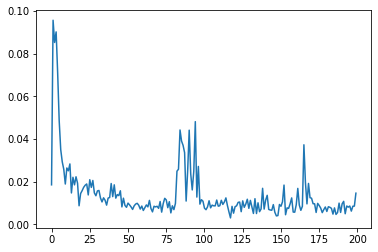

In [71]:
plt.plot(losses)

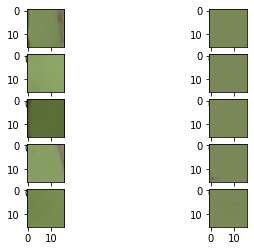

In [58]:
# check some generated samples

inputs, ind = next(iter(dataloader))
enc = inputs.to(device, torch.float)
dec,mu,logvar = vae(enc)
for i in range(5):
  plt.subplot(5,2, 2*i+1)
  plt.imshow(np.array(T.functional.to_pil_image(enc[i])))
  plt.subplot(5,2, 2*i+2)
  plt.imshow(np.array(T.functional.to_pil_image(dec[i])))

# 5. Segmentation

* Let $r^l(x)$ represents the reconstruction
residual (squared euclidean distance) of superpixel
$x$ calculated in $l^{th}$ hidden layer. Then the final reconstruction
residual is defined as the combination of reconstruction
residuals in different hidden representations, 
$r(x)=∑_{l}w_lr^l(x)$.
* $E(z)=\frac{∑_{s=1}^{N_s}w_{zn}(s)ɛ_n(s)}{∑_{s=1}^{N_s}w_{zn}(s)}$,$w_{zn}(s)=\frac{1}{||f(z)-v_n(s)||_2}$, where $N_s$ is the number of scale, and "$ɛ_n(s)$ is the superpixel level
saliency in scale $s$. $f_z$ is the low-level detail features
of pixel $z$, which consist of Lab and RGB color features and
coordinate of $z$. $n^{(s)}$ denotes the label of the superpixel containing
pixel $z$ at scale $s$ and $v_n(s)$ is the mean low-level
detail features of all pixels in superpixel $n^{(s)}$. Thus, $w_{zn}(s)$
regards the similarity of pixel $z$ with its corresponding superpixel
as the weight to average the reconstruction residuals in
multi-scale.

In [59]:
# Implemented multiscale Segmentation with scales 150, 250, 350 for SLIC algorithm

scales = [150, 250, 350]

SuperProp = {}

ims = torch.zeros_like(imT[0])
dists = torch.zeros_like(imT[0])

for scale in scales:
  seg = slic(im, n_segments = scale, compactness = 20, start_label=1)
  out = color.label2rgb(seg, im, kind='avg', bg_label = 0)
  props = regionprops(seg, intensity_image=np.asarray(im))  # properties of all SuperPixel
  SPD = SuperPixelDataset(props, Dtransform)
  DL = torch.utils.data.DataLoader(SPD, batch_size = batch_size,
                                          shuffle=True, num_workers=2) 
  
  # wzn(s) is calculated:
  dist = np.zeros_like(ims)       
  for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
      dist[i,j] = 1/np.linalg.norm(im[i,j] - out[i,j])

  # wzn(s)e(s) is calculated:
  for i, data in enumerate(DL, 0):
    # print(i)
    inp, indices = data
    for j in range(inp.shape[0]):
      # print(j)
      inputs = inp[j].unsqueeze(0); index = indices[j].unsqueeze(0)
      enc = inputs.to(device, torch.float)
      recon_images, mu, logvar = vae(enc)
      _, rec, _, _ = loss_fn(recon_images, enc, index.to(device), mu, logvar, alpha, 0)
      
      props[index].saliencyMap = rec
      rec_im = torch.ones_like(recon_images[0]) * rec

      filter1 = np.zeros_like(ims)
      bbox = props[index].bbox
      rec_im = T.functional.resize(rec_im, (bbox[2] - bbox[0], bbox[3] - bbox[1]))
      for coord in props[index].coords:
        filter1[coord[0]][coord[1]] = rec_im[0][coord[0] - bbox[0]][coord[1] - bbox[1]] \
                                            * dist[coord[0]][coord[1]]
      ims = ims+ filter1  

  SuperProp[scale] = props
  dists = dists + dist

# E(z) is calculated:
SegIm = ims / dists

### Display Segmented Image

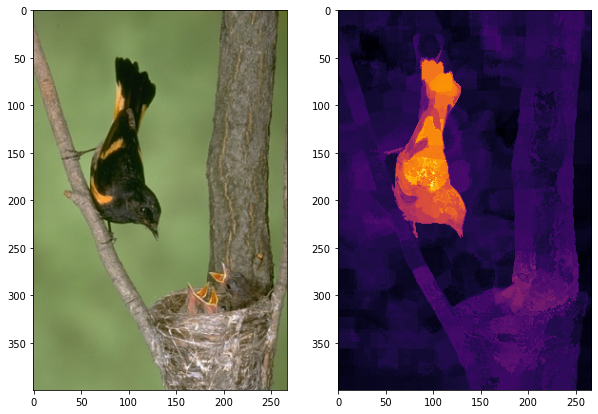

In [60]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(SegIm, cmap = 'inferno')

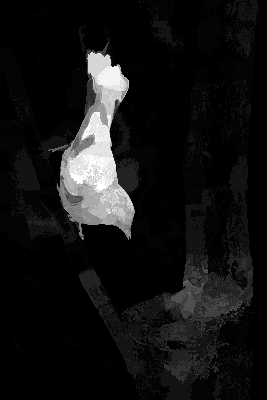

In [61]:
display.display(T.functional_pil.adjust_contrast(T.functional.to_pil_image(SegIm), 15))

# 7. Results

### Evaluation Metrics 
We have used **F-measure** and **mean absolute error (MAE)** to evalute the model. MAE can be calculated using the GT images in the dataset and the output from the model.

*   $𝙵_{β}=\frac{(1+β^2)\times Precision \times Recall}{β^2\times Precision \times Recall}$, where $β^2=0.3$.
*   $MAE=\frac{1}{W\times H}∑_{x=1}^{W}∑_{y=1}^{H}|S(x,y)-G(x,y)|$, where $W$ and $H$ are the width and height of the input image, $S(x, y)$ and $G(x, y)$ are the pixel values of the saliency map
and the binary ground truth at $(x, y)$, respectively.


MAE score : 0.1255470185638202
fbeta_score : 0.843486483961098


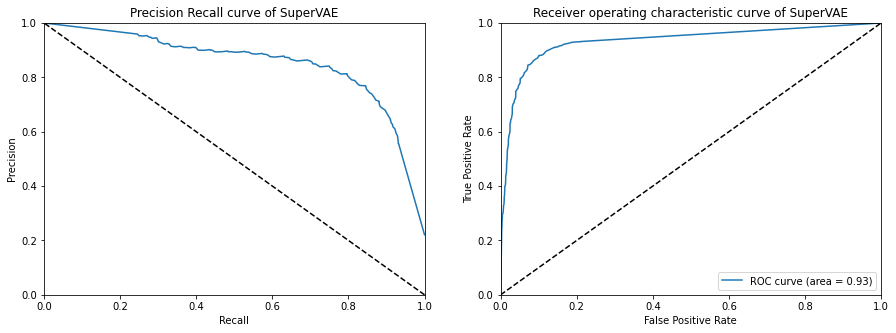

In [ ]:
from skimage.metrics import adapted_rand_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, precision_recall_curve, roc_curve, auc, fbeta_score
from skimage.util import img_as_float
import glob

'''
for the GT images make a folder named "GT" and
for testing images make a folder named "test"
'''
true = []
test = []

for imtrue, imtest in zip(glob.glob("/content/GT/*.png"), glob.glob("/content/test/*.png")):
  im_true = io.imread(imtrue)
  im_test = io.imread(imtest)

  im_truef = img_as_float(im_true)
  im_testf = img_as_float(im_test) 

  error, precision, recall = adapted_rand_error(im_true, im_test)
  true.append(im_true.flatten())
  test.append(im_test.flatten())
  

# make the True labels binary and obtained scores in between (-1, 1)
true = np.concatenate(true, axis=0) / 255
test = np.concatenate(test, axis=0) / 255

print(f"MAE score : {mean_absolute_error(true, test)}")
print(f"fbeta_score : {fbeta_score(true > 0.5 , test > 0.5, beta = 0.3)}")


# Plot Precision Recall Curves
precision, recall, thresholds = precision_recall_curve(true, test) 

fig, (ax, ax_) = plt.subplots(1,2, sharey=False, figsize=(15, 5))#, squeeze=False)
ax.plot(recall, precision)
ax.plot([1, 0], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve of SuperVAE')


fpr, tpr, thresholds = roc_curve(true, test) 
roc_auc = auc(fpr,tpr)

ax_.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax_.plot([0, 1], [0, 1], 'k--')
ax_.set_xlim([0.0, 1.0])
ax_.set_ylim([0.0, 1.0])
ax_.set_xlabel('False Positive Rate')
ax_.set_ylabel('True Positive Rate')
ax_.set_title('Receiver operating characteristic curve of SuperVAE')
ax_.legend(loc="lower right")

plt.show()

## Qualitative Evaluation
Some of the Saliency Maps obtained using our framework is shown below. One can see that this method is very much effective to detect
the salient objects accurately, and obtain more clear object boundaries for input images.

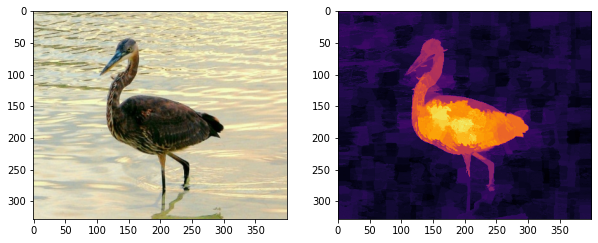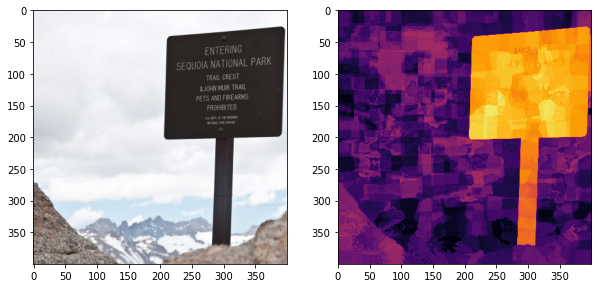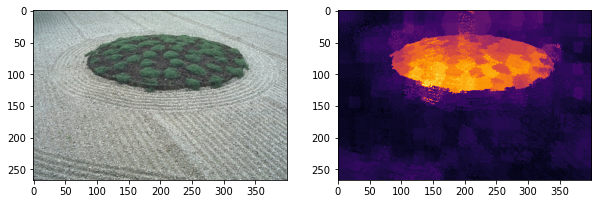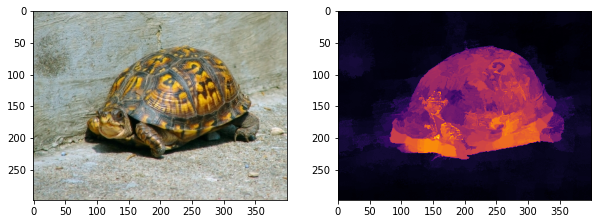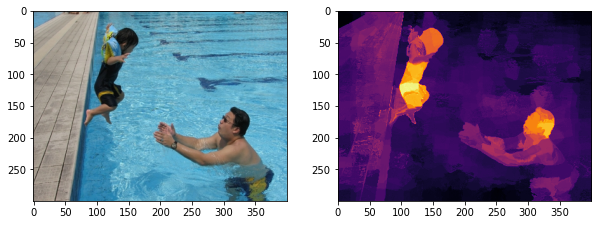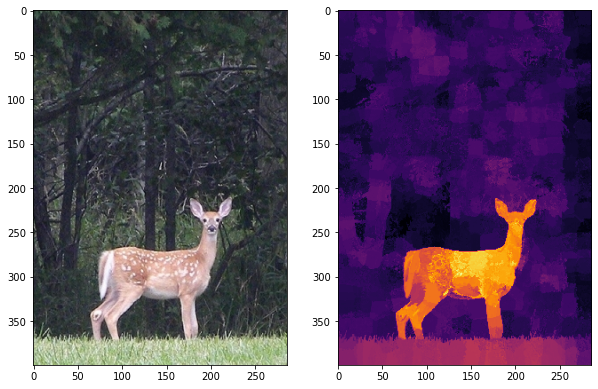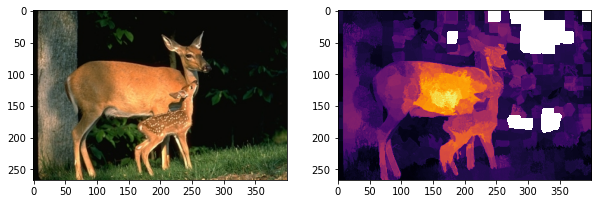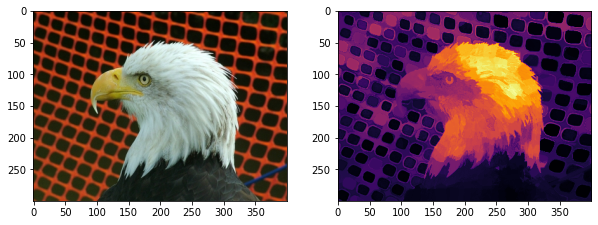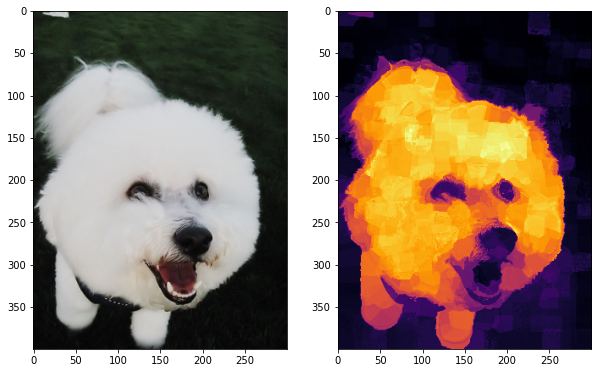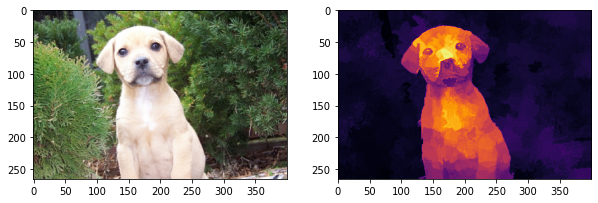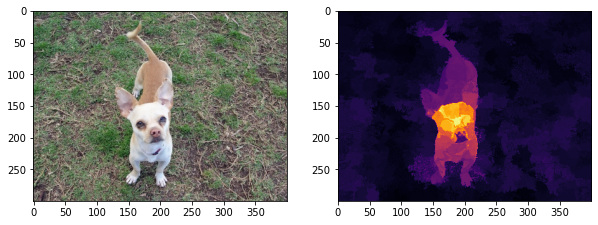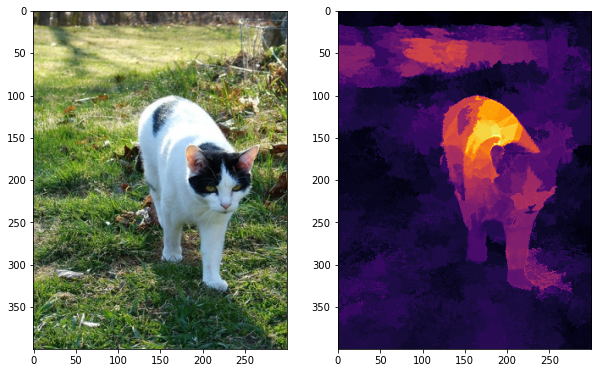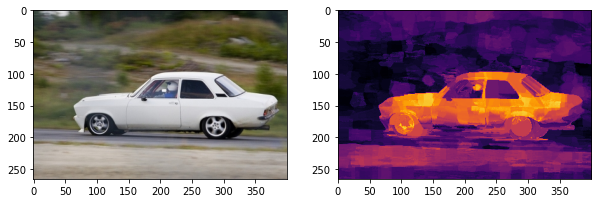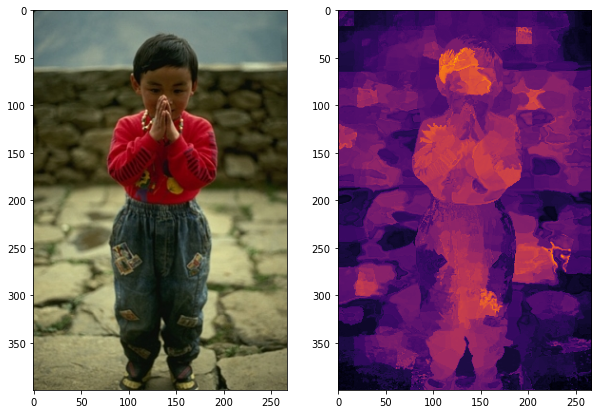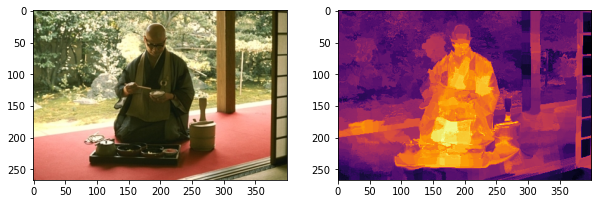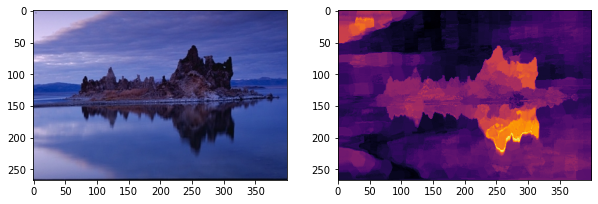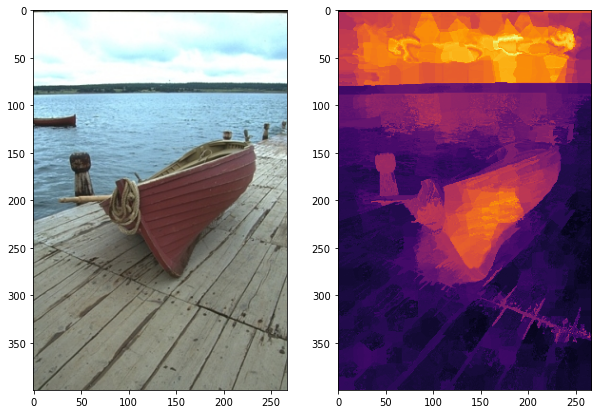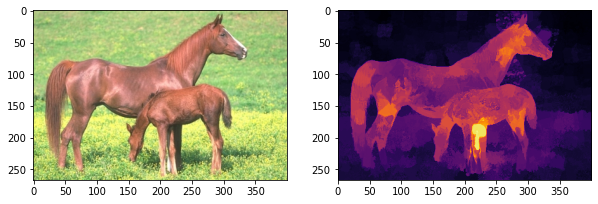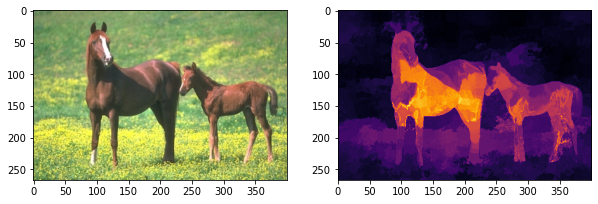